In [89]:
import  yfinance as yf
data=yf.download("AAPL", start="2015-01-01", end="2025-01-01")
data.to_csv("apple_stock.csv")

[*********************100%***********************]  1 of 1 completed


In [90]:
print(data.head())



Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261049  24.729272  23.821673  24.718176  212818400
2015-01-05  23.577570  24.110146  23.391169  24.030260  257142000
2015-01-06  23.579798  23.839428  23.218089  23.641931  263188400
2015-01-07  23.910435  24.010292  23.677432  23.788385  160423600
2015-01-08  24.829130  24.886826  24.121248  24.238859  237458000


In [91]:
import pandas as pd
df=pd.read_csv(r"apple_stock.csv")
df = df.drop(index=0)
df = df.drop(index=1)
df=df.reset_index(drop=True)
df.rename(columns={df.columns[0]:"Date"},inplace=True)
df.head()

,Date,Close,High,Low,Open,Volume
0,2015-01-02,24.261049270629883,24.729272337596463,23.82167345251905,24.71817633026032,212818400
1,2015-01-05,23.57756996154785,24.110145998105324,23.391169279909636,24.030259507971074,257142000
2,2015-01-06,23.579797744750977,23.839428081950576,23.21808887323788,23.64193132701962,263188400
3,2015-01-07,23.91043472290039,24.010292009735185,23.677432129602,23.78838542297973,160423600
4,2015-01-08,24.829130172729492,24.886826364711517,24.12124755318299,24.238859477265255,237458000


In [92]:
print(df.columns)
df.dtypes


Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


Date      object
Close     object
High      object
Low       object
Open      object
Volume    object
dtype: object

In [93]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
df.dtypes


Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object

In [94]:
from sqlalchemy import create_engine

username = "root"
password = "#"
host = "localhost"
port = "3006"
database = "finance"

# Create connection engine
engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}")


df.to_sql("stock_prices", con=engine, if_exists="replace", index=False)


2516

In [95]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")




df=df.sort_values(by="Date",ascending=True)
df.head()
df.dtypes



Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object

In [99]:
df['return'] = df['Close'].pct_change()
df['target'] = df['return'].shift(-1)

df.head()
df = df.dropna().reset_index(drop=True)
df.head()

,Date,Close,High,Low,Open,Volume,return,target
0,2015-01-06,23.579798,23.839428,23.218089,23.641931,263188400,0.000094,0.014022
1,2015-01-07,23.910435,24.010292,23.677432,23.788385,160423600,0.014022,0.038422
2,2015-01-08,24.829130,24.886826,24.121248,24.238859,237458000,0.038422,0.001073
3,2015-01-09,24.855761,25.130924,24.456328,25.002218,214798000,0.001073,-0.024641
4,2015-01-12,24.243294,24.993337,24.143436,24.986680,198603200,-0.024641,0.008879


In [100]:
df['oc_spread'] = (df['Close'] - df['Open']) / df['Open']
df['hl_spread'] = (df['High'] - df['Low']) / df['Close']
df['ema_8'] = df['Close'].ewm(span=8).mean()
df['ema_21'] = df['Close'].ewm(span=21).mean()
df['ema_diff'] = df['ema_8'] - df['ema_21']
for window in [3, 5, 10, 20]:
        df[f'roll_mean_{window}'] = df['return'].rolling(window).mean()
        df[f'roll_std_{window}'] = df['return'].rolling(window).std()
df

,Date,Close,High,Low,Open,Volume,return,target,oc_spread,hl_spread,...,ema_21,ema_diff,roll_mean_3,roll_std_3,roll_mean_5,roll_std_5,roll_mean_10,roll_std_10,roll_mean_20,roll_std_20
0,2015-01-06,23.579798,23.839428,23.218089,23.641931,263188400,0.000094,0.014022,-0.002628,0.026350,...,23.579798,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-07,23.910435,24.010292,23.677432,23.788385,160423600,0.014022,0.038422,0.005131,0.013921,...,23.752989,0.012793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-08,24.829130,24.886826,24.121248,24.238859,237458000,0.038422,0.001073,0.024352,0.030834,...,24.146382,0.065675,0.017513,0.019401,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-09,24.855761,25.130924,24.456328,25.002218,214798000,0.001073,-0.024641,-0.005858,0.027140,...,24.349826,0.087837,0.017839,0.018965,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-12,24.243294,24.993337,24.143436,24.986680,198603200,-0.024641,0.008879,-0.029751,0.035057,...,24.324278,0.053007,0.004951,0.031710,0.005794,0.022986,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,2024-12-20,253.589767,254.097958,244.820894,247.162572,147495300,0.018816,0.003065,0.026004,0.036583,...,243.177125,5.761079,0.001470,0.020684,0.005171,0.015495,0.004757,0.011580,0.005434,0.008878
2508,2024-12-23,254.367020,254.745665,252.553450,253.868788,40858800,0.003065,0.011478,0.001963,0.008618,...,244.194388,5.950220,0.009632,0.008195,0.003439,0.015057,0.003454,0.010873,0.005292,0.008893
2509,2024-12-24,257.286652,257.296596,254.386927,254.586231,23234700,0.011478,0.003176,0.010607,0.011309,...,245.384594,6.347135,0.011120,0.007882,0.003790,0.015260,0.004188,0.011168,0.005213,0.008828
2510,2024-12-26,258.103729,259.179926,256.718662,257.276679,27237100,0.003176,-0.013242,0.003215,0.009536,...,246.540879,6.606850,0.005906,0.004826,0.008710,0.006617,0.005022,0.010693,0.004902,0.008782


In [101]:
n_test = int(len(df) * 0.2)
n_test

502

In [106]:
df = df.dropna().reset_index(drop=True)
feature_cols = [c for c in df.columns if c.startswith(('ret_', 'roll_', 'ema_'))]
X = df[feature_cols]
y = df['target']
n_test = int(len(df) * 0.2)
X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

linreg = LinearRegression()
linreg.fit(X_train_s, y_train)


y_pred = linreg.predict(X_test_s)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linreg.coef_
}).sort_values(by='Coefficient', ascending=False)


print(coef_df.head(5))

         Feature  Coefficient
9   roll_mean_20     0.001344
8    roll_std_10     0.001143
10   roll_std_20     0.000346
5    roll_mean_5     0.000215
1         ema_21    -0.000159


In [110]:
import pandas as pd
import sqlite3

# Example: include date index or a column for plotting
results_df = pd.DataFrame({
    'Date': df.iloc[-len(y_test):]['Date'],  # adjust if your date column is named differently
    'Actual_Close': y_test.values,
    'Predicted_Close': y_pred
})

# Save to SQL
df.to_sql("results_df", con=engine, if_exists="replace", index=False)
results_df.to_sql("report_df", con=engine, if_exists="replace", index=False)

498

In [ ]:
power bi to sql, database, mysql, server : localhost:3006, user: root, pass: database:finance

In [111]:
df.head()

,Date,Close,High,Low,Open,Volume,return,target,oc_spread,hl_spread,...,ema_21,ema_diff,roll_mean_3,roll_std_3,roll_mean_5,roll_std_5,roll_mean_10,roll_std_10,roll_mean_20,roll_std_20
0,2015-02-03,26.329208,26.426846,26.098425,26.295922,207662800,0.000168,0.007670,0.001266,0.012474,...,25.194129,0.532462,-0.000640,0.013609,0.017149,0.027687,0.009061,0.025176,0.005775,0.022587
1,2015-02-04,26.531151,26.741963,26.253768,26.295930,280598800,0.007670,0.007138,0.008945,0.018401,...,25.334667,0.571632,0.006795,0.006235,0.007377,0.016790,0.009064,0.025176,0.006153,0.022551
2,2015-02-05,26.720520,26.785127,26.566800,26.738341,168984800,0.007138,-0.008421,-0.000667,0.008171,...,25.478298,0.609660,0.004992,0.004186,0.002578,0.010585,0.007176,0.024462,0.005809,0.022477
3,2015-02-06,26.495506,26.789579,26.388570,26.738338,174826400,-0.008421,0.006642,-0.009082,0.015135,...,25.582397,0.596408,0.002129,0.009140,0.003820,0.008142,0.005818,0.024958,0.003467,0.021310
4,2015-02-09,26.671501,26.698234,26.384112,26.410846,155559200,0.006642,0.019212,0.009869,0.011777,...,25.692595,0.595962,0.001786,0.008843,0.002639,0.006892,0.006376,0.024902,0.003745,0.021313


In [113]:
df_return=df['return']
df_return.head()

0    0.000168
1    0.007670
2    0.007138
3   -0.008421
4    0.006642
Name: return, dtype: float64

# Normality test for Forex return

In [118]:
df_return
import scipy.stats as stats
import seaborn as sns
#Shapiro-wilk test
stats.shapiro(df_return)


ShapiroResult(statistic=0.9414587616920471, pvalue=2.476839571871859e-30)

##### Result: data is not normally distributed

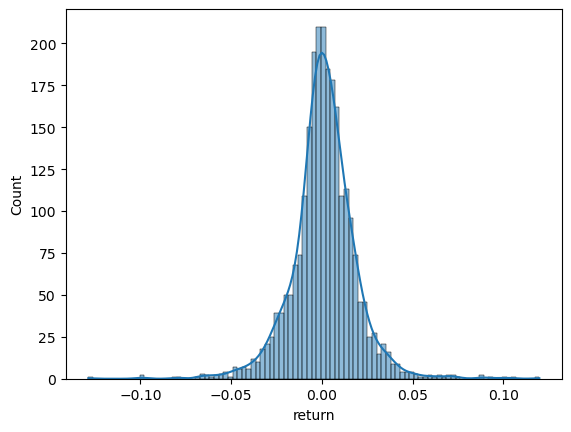

In [120]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.histplot(df_return,kde=True)
plt.show()

<Axes: xlabel='return', ylabel='Density'>

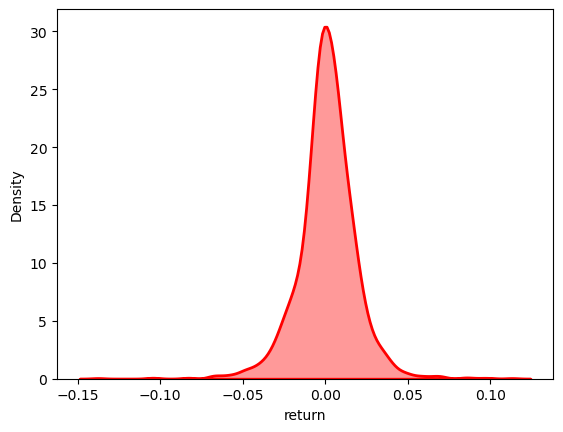

In [123]:
#compute log return
log_return=df['log_return']=df['return'].apply(lambda x:np.log(1+x))
import seaborn as sns
sns.kdeplot(log_return,fill=True,color='red',linewidth=2,alpha=0.4)

# Q-Q plot

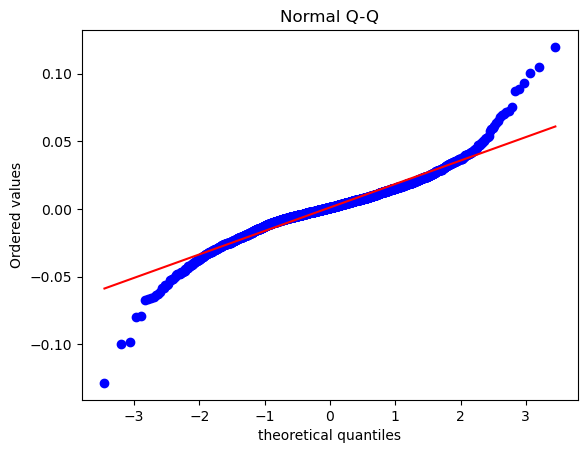

In [126]:
import scipy.stats as stats
stats.probplot(df_return,dist="norm",plot=plt)
import matplotlib.pyplot as plt
plt.title("Normal Q-Q")
plt.xlabel('theoretical quantiles')
plt.ylabel('Ordered values')
plt.show()

##### result: under dispered distribution

# Autocorrelation chart

(array([ 1.        , -0.0672312 , -0.00245667, -0.02055936, -0.00598877,
        0.03452564, -0.03335166,  0.08580227, -0.08095095,  0.09140887,
       -0.03242089,  0.00740852,  0.01474573, -0.02974673,  0.03843108,
       -0.04731988,  0.03318492, -0.01233091,  0.05407535,  0.02662764,
       -0.02144071]), array([[ 1.        ,  1.        ],
       [-0.10649335, -0.02796905],
       [-0.04189588,  0.03698255],
       [-0.05999881,  0.01888009],
       [-0.04544474,  0.0334672 ],
       [-0.00493174,  0.07398301],
       [-0.07285557,  0.00615226],
       [ 0.04625498,  0.12534957],
       [-0.12078418, -0.04111773],
       [ 0.05132285,  0.1314949 ],
       [-0.07282696,  0.00798517],
       [-0.03303762,  0.04785466],
       [-0.0257025 ,  0.05519396],
       [-0.07020324,  0.01070979],
       [-0.00205914,  0.0789213 ],
       [-0.0878663 , -0.00677347],
       [-0.00744654,  0.07381637],
       [-0.05300412,  0.0283423 ],
       [ 0.01339638,  0.09475432],
       [-0.01416199,  0.

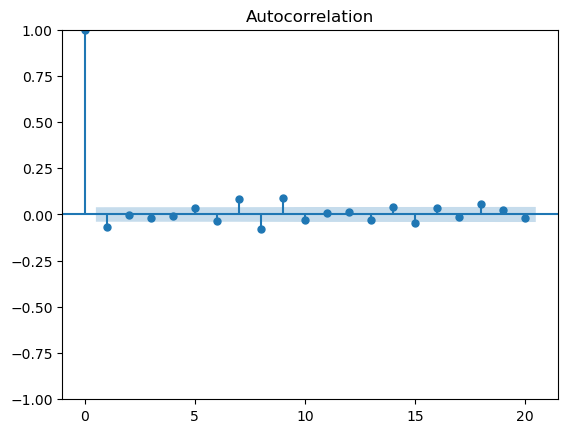

In [144]:

from statsmodels.graphics.tsaplots import plot_acf



# compute log return
log_return = np.log(df['Close'] / df['Close'].shift(1))

# drop NaN
Return = log_return.dropna()

# ACF calculation
acf_value = acf(Return, alpha=0.05,nlags=20)
print(acf_value)

# Plot ACF
plot_acf(Return, alpha=0.05,lags=20)
plt.show()

# Boxplot - distribution and outlier

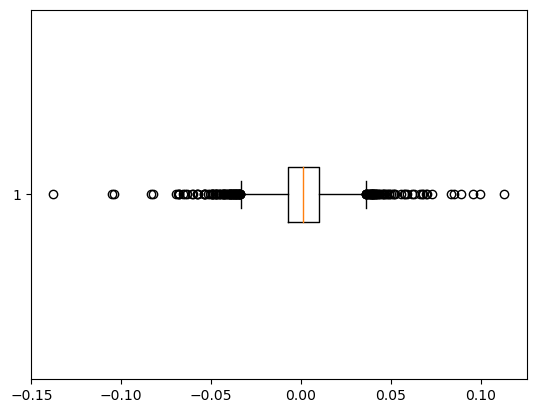

In [154]:
log_Return=np.log(df['Close']/df['Close'].shift(1)).dropna()
import matplotlib.pyplot as plt
plt.boxplot(log_Return,vert=False)
plt.show()



# Measuring outlier

In [157]:
Q1=log_Return.quantile(0.25)
Q3=log_Return.quantile(0.75)
IQR=Q3-Q1
outlier=log_Return[(log_Return<Q1-1.5*IQR)|(log_Return>Q3+1.5*IQR)]
print(outlier)

117    -0.043215
131    -0.053441
139    -0.063113
142     0.055771
146    -0.045727
          ...   
2312    0.042361
2328    0.058096
2354    0.070131
2391   -0.049366
2423    0.036395
Name: Close, Length: 133, dtype: float64


# Forex pairs in yfinance and correlation

[*********************100%***********************]  4 of 4 completed


Ticker    AUDUSD=X  EURUSD=X  GBPUSD=X  USDJPY=X
Ticker                                          
AUDUSD=X  1.000000  0.545046  0.566418 -0.275514
EURUSD=X  0.545046  1.000000  0.605396 -0.413109
GBPUSD=X  0.566418  0.605396  1.000000 -0.256643
USDJPY=X -0.275514 -0.413109 -0.256643  1.000000


<Axes: xlabel='Ticker', ylabel='Ticker'>

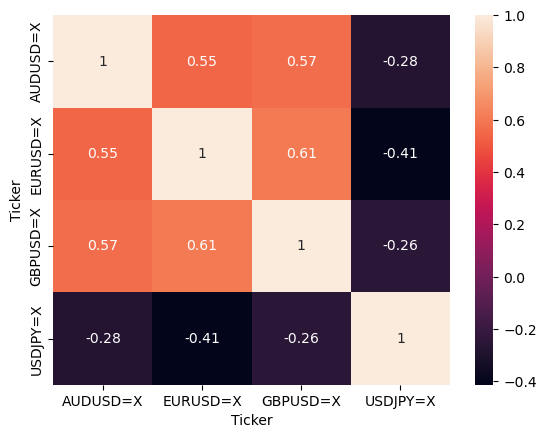

In [151]:

import yfinance as yf
import pandas as pd
import seaborn as sns

pairs = ["EURUSD=X", "GBPUSD=X", "USDJPY=X", "AUDUSD=X"]
fx_data=yf.download(pairs,start="2015-01-01", end="2025-01-01")['Close']
fx_return=fx_data.pct_change().dropna()
corr_matrix=fx_return.corr()
print(corr_matrix)
sns.heatmap(corr_matrix,annot=True)
